# Visualize gene expression

This notebook visualizes the gene expression data for the template and simulated experiments in order to:
1. Validate that the structure of the gene expression data and simulated data are consistent
2. To visualize the signal that is in the experiments

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [2]:
import os
import pandas as pd
import umap
import pickle
import glob
from keras.models import load_model
from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)
from ponyo import utils
from generic_expression_patterns_modules import plot

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Load config parameters

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_33245.tsv")
)

params = utils.read_config(config_filename)

In [4]:
# Load config params

local_dir = params['local_dir']
project_id = params['project_id']
num_simulated = params['num_simulated']

pval_name = "adj.P.Val"
logFC_name = "logFC"
#vae_model_dir = params['vae_model_dir']
#normalized_template_filename = params['normalized_template_filename']
#normalized_compendium_filename = params['normalized_compendium_filename']
#scaler_filename = params['scaler_filename']

## Volcano plots

In [5]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats[pval_name]<0.01) & (abs(template_DE_stats[logFC_name])>1)]
print(selected.shape)

(122, 6)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


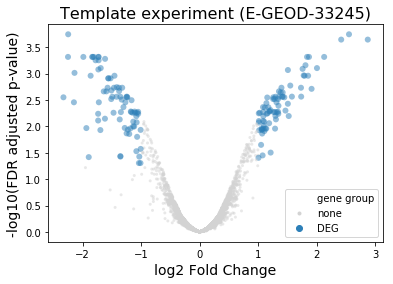

In [6]:
plot.make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
    pval_name,
    logFC_name
)

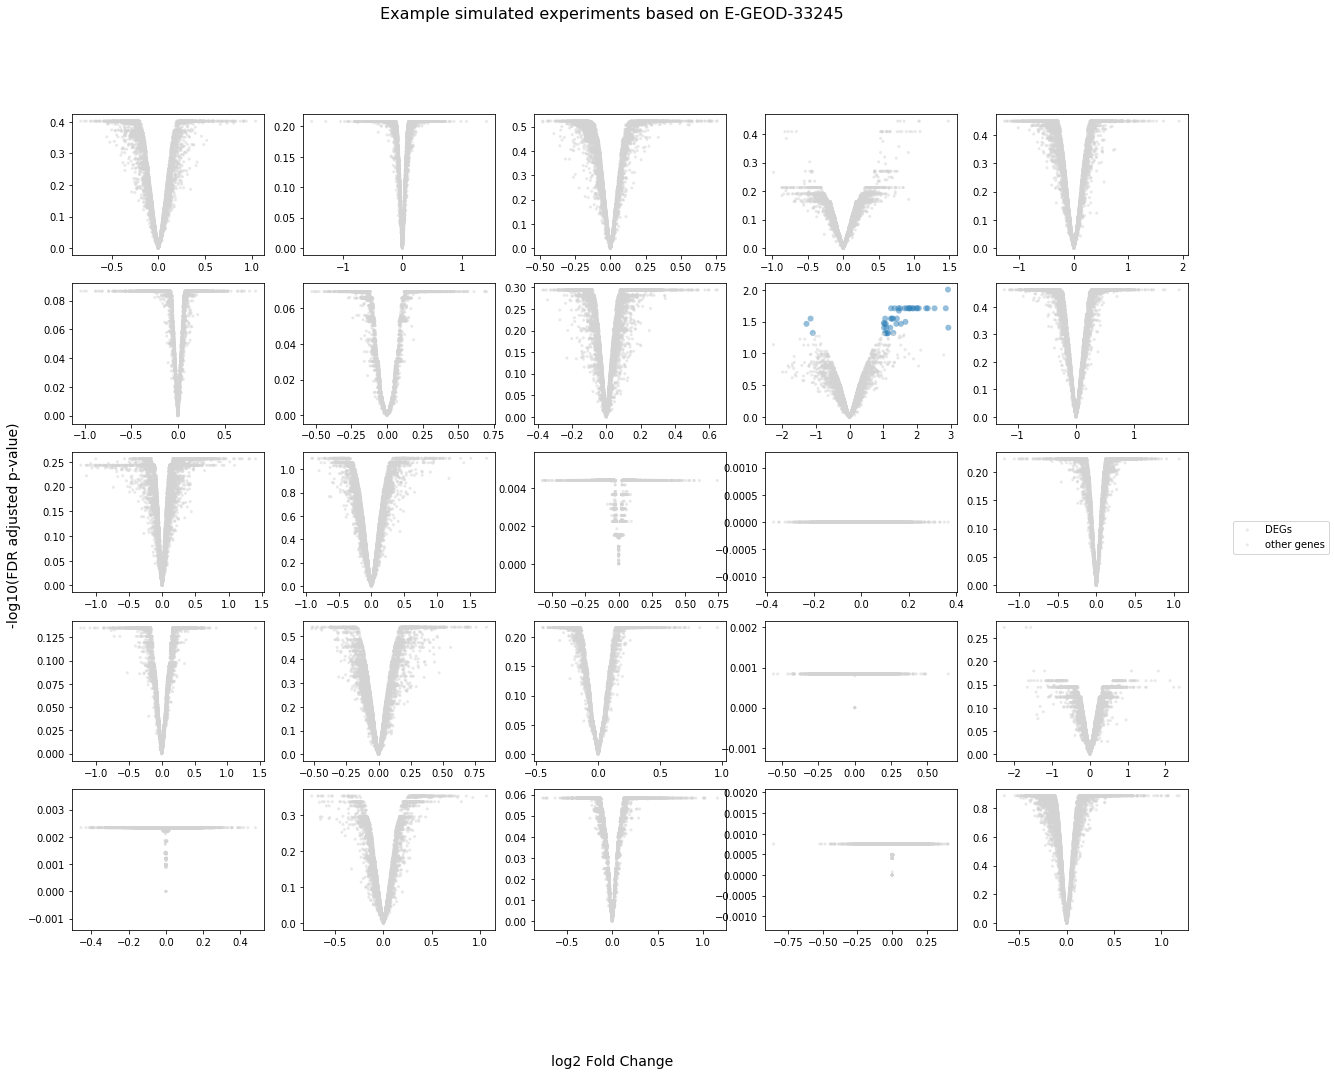

In [7]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")

plot.make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    pval_name,
    logFC_name,
    num_simulated,
    5,
    5,
    20,
    15
)

## Plot gene expression in gene space

In [8]:
"""run=2

simulated_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_data_{project_id}_{run}.txt"
)"""

'run=2\n\nsimulated_filename = os.path.join(\n    local_dir,\n    "pseudo_experiment",\n    f"selected_simulated_data_{project_id}_{run}.txt"\n)'

In [9]:
"""normalized_compendium_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)
normalized_template_data = pd.read_csv(normalized_template_filename, sep="\t", index_col=0, header=0)
simulated_data = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

print(normalized_template_data.shape)
normalized_template_data.head()"""

'normalized_compendium_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)\nnormalized_template_data = pd.read_csv(normalized_template_filename, sep="\t", index_col=0, header=0)\nsimulated_data = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)\n\nprint(normalized_template_data.shape)\nnormalized_template_data.head()'

In [10]:
"""# Normalize simulated_data
# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

normalized_simulated_data = scaler.transform(simulated_data)

normalized_simulated_data = pd.DataFrame(
    normalized_simulated_data,
    columns=simulated_data.columns,
    index=simulated_data.index,
)

print(normalized_simulated_data.shape)
normalized_simulated_data.head()"""

'# Normalize simulated_data\n# Load pickled file\nwith open(scaler_filename, "rb") as scaler_fh:\n    scaler = pickle.load(scaler_fh)\n\nnormalized_simulated_data = scaler.transform(simulated_data)\n\nnormalized_simulated_data = pd.DataFrame(\n    normalized_simulated_data,\n    columns=simulated_data.columns,\n    index=simulated_data.index,\n)\n\nprint(normalized_simulated_data.shape)\nnormalized_simulated_data.head()'

In [11]:
"""# Label samples 
normalized_compendium_data['sample group'] = "compendium"
normalized_template_data['sample group'] = "template"
normalized_simulated_data['sample group'] = "simulated"""

'# Label samples \nnormalized_compendium_data[\'sample group\'] = "compendium"\nnormalized_template_data[\'sample group\'] = "template"\nnormalized_simulated_data[\'sample group\'] = "simulated'

In [12]:
"""normalized_all_data = pd.concat([normalized_template_data,
                             normalized_simulated_data,
                             normalized_compendium_data
])"""

'normalized_all_data = pd.concat([normalized_template_data,\n                             normalized_simulated_data,\n                             normalized_compendium_data\n])'

In [13]:
"""# Plot

# Drop label column
normalized_all_data_numeric = normalized_all_data.drop(['sample group'], axis=1)

model = umap.UMAP(random_state=1).fit(normalized_all_data_numeric)

normalized_all_data_UMAPencoded = model.transform(normalized_all_data_numeric)
normalized_all_data_UMAPencoded_df = pd.DataFrame(data=normalized_all_data_UMAPencoded,
                                         index=normalized_all_data.index,
                                         columns=['1','2'])

# Add back label column
normalized_all_data_UMAPencoded_df['sample group'] = normalized_all_data['sample group']

# Plot
fig = ggplot(normalized_all_data_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='sample group'), alpha=0.1)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'Gene expression data in gene space')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)"""

'# Plot\n\n# Drop label column\nnormalized_all_data_numeric = normalized_all_data.drop([\'sample group\'], axis=1)\n\nmodel = umap.UMAP(random_state=1).fit(normalized_all_data_numeric)\n\nnormalized_all_data_UMAPencoded = model.transform(normalized_all_data_numeric)\nnormalized_all_data_UMAPencoded_df = pd.DataFrame(data=normalized_all_data_UMAPencoded,\n                                         index=normalized_all_data.index,\n                                         columns=[\'1\',\'2\'])\n\n# Add back label column\nnormalized_all_data_UMAPencoded_df[\'sample group\'] = normalized_all_data[\'sample group\']\n\n# Plot\nfig = ggplot(normalized_all_data_UMAPencoded_df, aes(x=\'1\', y=\'2\'))\nfig += geom_point(aes(color=\'sample group\'), alpha=0.1)\nfig += labs(x =\'UMAP 1\',\n            y = \'UMAP 2\',\n            title = \'Gene expression data in gene space\')\nfig += theme_bw()\nfig += theme(\n    legend_title_align = "center",\n    plot_background=element_rect(fill=\'white\'),\n 

## Plot gene expression data in latent space

In [14]:
"""# Model files
model_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_weights.h5"))[0]

model_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_weights.h5"))[0]"""

'# Model files\nmodel_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_model.h5"))[0]\n\nweights_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_weights.h5"))[0]\n\nmodel_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_model.h5"))[0]\n\nweights_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_weights.h5"))[0]'

In [15]:
"""# Load saved models
loaded_model = load_model(model_encoder_filename, compile=False)
loaded_decode_model = load_model(model_decoder_filename, compile=False)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)"""

'# Load saved models\nloaded_model = load_model(model_encoder_filename, compile=False)\nloaded_decode_model = load_model(model_decoder_filename, compile=False)\n\nloaded_model.load_weights(weights_encoder_filename)\nloaded_decode_model.load_weights(weights_decoder_filename)'

In [16]:
"""# Encode concatenated normalized data
normalized_data_encoded = loaded_model.predict_on_batch(normalized_all_data_numeric)
normalized_data_encoded_df = pd.DataFrame(normalized_data_encoded, index=normalized_all_data_numeric.index)"""

'# Encode concatenated normalized data\nnormalized_data_encoded = loaded_model.predict_on_batch(normalized_all_data_numeric)\nnormalized_data_encoded_df = pd.DataFrame(normalized_data_encoded, index=normalized_all_data_numeric.index)'

In [17]:
"""model2 = umap.UMAP(random_state=1).fit(normalized_data_encoded_df)

normalized_encoded_data_UMAPencoded = model2.transform(normalized_data_encoded_df)
normalized_encoded_data_UMAPencoded_df = pd.DataFrame(data=normalized_encoded_data_UMAPencoded,
                                         index=normalized_data_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
normalized_encoded_data_UMAPencoded_df['sample group'] = normalized_all_data['sample group']

# Plot
fig = ggplot(normalized_encoded_data_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='sample group'), alpha=0.1)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'Gene expression data in latent space')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)"""

'model2 = umap.UMAP(random_state=1).fit(normalized_data_encoded_df)\n\nnormalized_encoded_data_UMAPencoded = model2.transform(normalized_data_encoded_df)\nnormalized_encoded_data_UMAPencoded_df = pd.DataFrame(data=normalized_encoded_data_UMAPencoded,\n                                         index=normalized_data_encoded_df.index,\n                                         columns=[\'1\',\'2\'])\n\n# Add back label column\nnormalized_encoded_data_UMAPencoded_df[\'sample group\'] = normalized_all_data[\'sample group\']\n\n# Plot\nfig = ggplot(normalized_encoded_data_UMAPencoded_df, aes(x=\'1\', y=\'2\'))\nfig += geom_point(aes(color=\'sample group\'), alpha=0.1)\nfig += labs(x =\'UMAP 1\',\n            y = \'UMAP 2\',\n            title = \'Gene expression data in latent space\')\nfig += theme_bw()\nfig += theme(\n    legend_title_align = "center",\n    plot_background=element_rect(fill=\'white\'),\n    legend_key=element_rect(fill=\'white\', colour=\'white\'), \n    legend_title=element